# w266: Final Project
### Christopher Danicic, Robert Deng, Chandan Gope
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [6]:
#Load libraries
import os, sys, re, json, time
import itertools, collections
from importlib import reload
import numpy as np

### Load data

In [7]:
#Load data
import data_utils; reload(data_utils)

data_loader = data_utils.DataLoader(path="./data")
train, test = data_loader.readTrainTest(verbose=True)

#Print some train data
train.head(n=20)

Loaded train.csv: Num rows = 159571, Num cols = 8
Loaded test.csv: Num rows = 153164, Num cols = 2
Train data column names: ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']
Test data column names: ['id' 'comment_text']


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


### Basic data exploration

In [17]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,100], bins=40, normed=True):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Number of tokens"
    fig.yaxis.axis_label = "Frequency"
    bp.show(fig)

Loading BokehJS ...

In [8]:
train_comment_text = train['comment_text']
sentences_lengths = train_comment_text.str.split().apply(len)
plot_length_histogram(sentences_lengths, x_range=[0,300])
print("95% percentile length: {:.0f}".format(sentences_lengths.quantile(.95)))

NameError: name 'plot_length_histogram' is not defined

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2156ba630>,
      dtype=object)

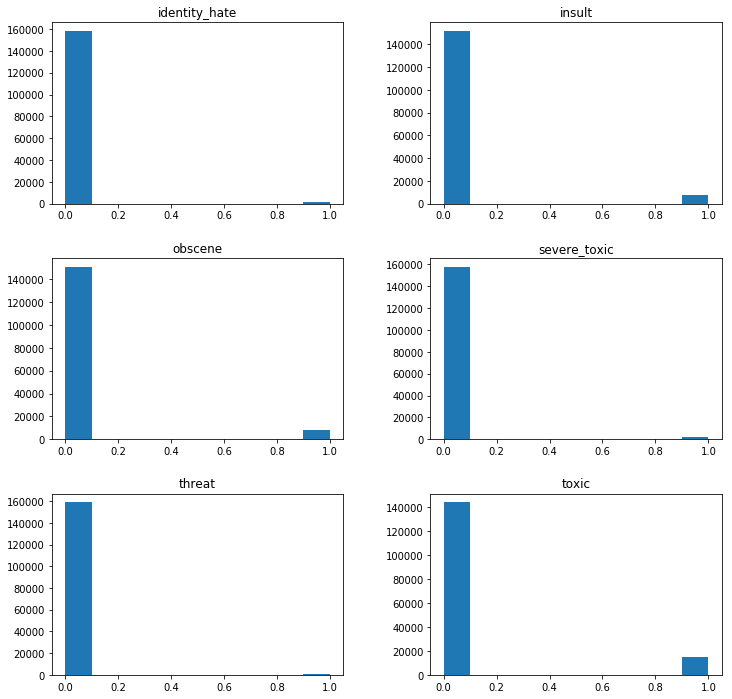

In [44]:
train.hist(grid=False, figsize=(12,12), column=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

## Baseline classifiers

### Logistic regression

In [ ]:
#!pip install sklearn
#!pip install scipy

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

submission = pd.DataFrame.from_dict({'id': test['id']})
scores = []
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    submission[class_name] = classifier.predict_proba(test_word_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

submission.to_csv('submission_logreg.csv', index=False)

CV score for class toxic is 0.9571332470683983
CV score for class severe_toxic is 0.9848181573816189
CV score for class obscene is 0.9799024539513609
CV score for class threat is 0.9772002163097356
CV score for class insult is 0.9694679262372441
CV score for class identity_hate is 0.9672950512882807
Total CV score is 0.9726361753727731


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

### USING 20% of train data as test

In [42]:
from sklearn import model_selection

train_80, test_20 = model_selection.train_test_split(train,test_size=0.2)

In [48]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_text = train_80['comment_text'] #train['comment_text']
test_text = test_20['comment_text'] #test['comment_text']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

prediction = pd.DataFrame.from_dict({'id': test_20['id']})
scores = []
for class_name in class_names:
    train_target = train_80[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('Cross Validation roc_auc score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    prediction[class_name] = classifier.predict(test_word_features)   

print('Total Cross Validation roc_auc score is {}'.format(np.mean(scores)))

print(prediction.size[0])
prediction.head(20)

Cross Validation roc_auc score for class toxic is 0.9561970976804676
Cross Validation roc_auc score for class severe_toxic is 0.9842853377501907
Cross Validation roc_auc score for class obscene is 0.9802194365288622
Cross Validation roc_auc score for class threat is 0.9735666650319654
Cross Validation roc_auc score for class insult is 0.9688236610588296
Cross Validation roc_auc score for class identity_hate is 0.9663050211248505
Total Cross Validation roc_auc score is 0.9715662031958611


IndexError: invalid index to scalar variable.

In [61]:
ET=test_20.set_index('id').subtract(prediction.set_index('id'),axis='columns')

In [67]:
ET.columns

Index(['comment_text', 'identity_hate', 'insult', 'obscene', 'severe_toxic',
       'threat', 'toxic'],
      dtype='object')

In [87]:
from collections import defaultdict

identity_hate=defaultdict(list)
insult= defaultdict(list)
obscene=defaultdict(list)
severe_toxic=defaultdict(list)
threat=defaultdict(list) 
toxic=defaultdict(list)

error_collection=[('identity_hate',identity_hate),('insult',insult),('obscene',obscene),\
                  ('severe_toxic',severe_toxic),('threat',threat),('toxic',toxic)]

categories=['identity_hate', 'insult', 'obscene', 'severe_toxic','threat', 'toxic']

In [73]:
for index, row in ET.iterrows():
    if row['identity_hate']==1:
        print(index)

a7ef10a3a8d098f0
12aeac37aa137df6
57e76c3fc10415e5
de004b9b12fa9a62
fc3efa2f6f025f6d
0d5ae3d5aea21f1b
a0fda2f0f4148c92
34c116438bb64bff
64a99915873bd1b9
87e3be3ef8f865e2
a056d6e5e9475bc2
9c5a7f42e4c75a39
d7aaabfd8799b464
b7afc5b6fa59b70a
4805dde830503df6
49d78b1a037f8564
bf3e08b8be31f02d
c4554042fc328130
170771c0fda966a0
82bd53a4825ed3fe
c9b01b1fd57937ea
37854e90918c9d78
f509a56f35598cf2
4a45dca11f649773
c92a5d13e9111933
ec9b2f8d6c88a666
323ea25513f54e6e
56311e1c0b2cbb52
79d74a5b7e1f03a5
cbab217a16ba4aa7
a5aef8658cc7cb6b
77dd2a485b8511ae
5d3a4816331d0adc
c1249b3df042ba62
e8b17f51bb8c847d
ce26cedc315e5d96
a7d10cc08ab33a03
60f227ddd3674182
a490a89efba3c2b2
22a02ecefd2741fd
e3e781b553958b5b
1d317ce7daaf3f81
4b96690c4c52afb0
ae3eff588eca865c
1926c91c07e0b9fb
b234d9ec33a529a0
acd0d77565fb6779
3183fb5770f09af0
6107ddb893988866
8a1d761ff333e75c
a0180e211c39fa80
6e16451b7ae1e1ba
6469e5ff1037c32c
eb5fd947903ff637
3f006abae2ee3011
ad64de0da179975b
2d252fa9f5debfb8
c4647e8a0eb2c11a
057894cf4738a5

In [88]:
for index, row in ET.iterrows():
    
    for cat,dic in error_collection:
        
        if row[cat]==-1:
            dic['type_1'].append(index)
        if row[cat]==1:
            dic['type_2'].append(index)

In [94]:
test_20.loc[test_20['id'].isin(identity_hate['type_1'])]['comment_text']


137419    GWAH!! (fuck you nigger)
109851    I am gay - Astroguyaz   
Name: comment_text, dtype: object

In [108]:
for cat,dic in error_collection:
    print(cat,' TYPE I error (false positive):', \
        test_20.loc[test_20['id'].isin(dic['type_1'])]['comment_text'].shape[0])
    
    #print('\n')
    print(cat,' TYPE II error (false negative):', \
        test_20.loc[test_20['id'].isin(dic['type_2'])]['comment_text'].shape[0])
    print('\n')

identity_hate  TYPE I error (false positive): 2
identity_hate  TYPE II error (false negative): 260


insult  TYPE I error (false positive): 55
insult  TYPE II error (false negative): 1080


obscene  TYPE I error (false positive): 18
obscene  TYPE II error (false negative): 963


severe_toxic  TYPE I error (false positive): 29
severe_toxic  TYPE II error (false negative): 288


threat  TYPE I error (false positive): 0
threat  TYPE II error (false negative): 92


toxic  TYPE I error (false positive): 28
toxic  TYPE II error (false negative): 1886




## NOTICE:

#### We get many more false negatives (predicting non-toxic when it should be toxic)

In [116]:
toxic_type2=test_20.loc[test_20['id'].isin(toxic['type_2'])][['id','comment_text','toxic']]

In [120]:
toxic_type2predict=prediction.loc[prediction['id'].isin(toxic['type_2'])][['id','toxic']]

In [121]:
toxic_type2predict.columns=['id','prediction']

In [122]:
checkover=toxic_type2.merge(toxic_type2predict,left_on='id',right_on='id',how='inner')

In [123]:
checkover.head(10)

,id,comment_text,toxic,prediction
0,3c1f86de3f135401,"WTF? \n\nWhy have i been blocked ?, i've done nuthin' wrong -",1,0
1,6106acd643a65403,"""\n\n A kitten for you! \n\nBecause Heavydpj is clearly a pussy that just trys to cause trouble\n\n \n""",1,0
2,64857075b6004537,Admin is a paid scumbag mole and there is NO other answer possible.,1,0
3,44cc5d68e400d503,HAHA THIS IS MY FUCKIN PAGE!!!!!!!!! I CAN DO WHATEVER I WANT!!!!!!,1,0
4,2eeeaec359ef7915,"""\n\n As much as I'd like to see you (and all contributors) a bit more civil, I must say, """"Oh, eat my penis"""" may be the funniest incivil comment I've ever seen. """,1,0
5,d04629f08a0e529c,""":::??? In what way is saying """"its useful"""" an NPOV issue?? If someone uses this for something, then its useful. In my case, I am reading an article on Markov logic networks, wherein linguistic reification is one of the early steps, followed by conversion to a lambda calculus form, and then many other steps. In this calculation, reification is a crucial step. The """"natural stupidity"""" article cited probably just says that using reified forms (aka QLF's or quasi-logical forms) in certain ways is stupid; it cannot claim that QLF's in and of themsels are useless. \n\n""",1,0
6,35b1b05b8251490b,Thanks. Also thanks for freezing the article. This dickheadery is kinda annoying at times.,1,0
7,ec0868ed080c9c5f,- I WANT AN ANSWER YOU SON OF A BITCHES.,1,0
8,5b04e5424b37ebb0,"ok mr. SS gestapo, block me, throw me in the ovens and gas me, i know you love to do it. SIEG HEIL is your motto so stick by it you hitler-loving bastard.",1,0
9,0b72df7a0e3d9943,"""\n\nYou abused your authority by blocking me improperly,, then you refused to apologize (“So tough”), then you tried to bully me (""""Do not revert like you have been ever again. Understood?"""" and now you are threatening me (""""I'm not suggesting this time: I'm telling you: you need to change the way you edit. Now.""""). Viriditas did ask you to block me for activity that was not a violation of the three revert rule - and you agreed!. Then he and Jayjg and sockpuppet friend continued to guard the Zionist hatchet job on Yasser Arafat preventing other editors from altering it and you dutifully protected the article for them while blocking me. You admit to being biased against me and then you block me and protect the Zionist version of Yasser Arafat. I think the question should be, """"who the hell do you think you are?"""" 06:00, 12 Dec 2004 (UTC)""",1,0


In [111]:
for cat,dic in error_collection:
    print(cat,' TYPE I error (false positive):')
    print(test_20.loc[test_20['id'].isin(dic['type_1'])]['comment_text'].tolist())
    print('\n')
    print(cat,' TYPE II error (false negative):')
    print(test_20.loc[test_20['id'].isin(dic['type_2'])]['comment_text'].tolist())
    print('\n'*3)

identity_hate  TYPE I error (false positive):
['GWAH!! (fuck you nigger)', 'I am gay - Astroguyaz']


identity_hate  TYPE II error (false negative):
["Suck it. \n\nBitch, suck my bigass cock, gag on it motherfucker.  I didn't vandalize shit, you bitchass punks in your Administrator's clique think you're the motherfucking bomb and shit, but you ain't got shit and you sure as all hell don't know shit.  Fuck, if I took a dump and put it on my keyboard the fucking shit would come up with a better contribution than you motherfucking gestopoing up in this bitch.", 'like wtf \n\nlook man, youre a graduate student in mathematical fucking ecology and you have pictures of amoebas on your homepage.  dont you have anything better to do?  you have a job?  what can you do as a mathematical ecologist?  what the FUCK do you want to do with your life????  GET OFF WIKIPEDIA YOU FUCKING DEAD BEAT!  jesus H. christ!  go get a girlfriend or something, or get an interesting job, or at the least, go play som

In [30]:
pd.set_option('display.max_colwidth', -1)

In [31]:
test[test['id']=='00001cee341fdb12']['comment_text']

0    Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
Name: comment_text, dtype: object

In [20]:
#for each class
#iterate through rows
# test if predict==1 and test_y==0 #type I
# if so, add to defaultdict() type_1[class].append(ID)
# test if predict==0 and test_y==1 #type II
# if so, add to defaultdict() type_2[class].append(ID)
#
#

In [32]:
submission.head(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,0,1,0,1,0
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0


#### Below we show an example of batching on a tiny dataset. Checkout tiny_data.csv

In [14]:
reload(data_utils)
data_loader = data_utils.DataLoader(path="./data")
tiny_data = data_loader.readTinyData(verbose=True)
bg = data_loader.batchGenerator(tiny_data, batch_size=2, num_epochs=3, verbose=True)

for i, (batch_comments, batch_labels) in enumerate(bg):
    print("\nBatch {0}\n----------".format(i+1))
    for c,l in zip(batch_comments, batch_labels):
        print(c,l)

Loaded tiny_data.csv: Num rows = 8, Num cols = 8
Column names: ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']

Batch 1
----------
b'This is insult comment' [0 0 0 0 1 0]
b'This is threat comment' [0 1 0 1 0 0]

Batch 2
----------
b'This is obscene comment' [1 0 1 0 0 0]
b'This is severe_toxic comment' [1 1 0 0 0 0]

Batch 3
----------
b'This is hate comment' [0 0 0 0 1 1]
b'This is toxic comment' [1 0 0 0 0 0]

Batch 4
----------
b'This is really bad comment' [1 1 1 1 1 1]
b'This is ok comment' [0 0 0 0 0 0]
*************Epoch 1 finished*************


Batch 5
----------
b'This is obscene comment' [1 0 1 0 0 0]
b'This is really bad comment' [1 1 1 1 1 1]

Batch 6
----------
b'This is ok comment' [0 0 0 0 0 0]
b'This is hate comment' [0 0 0 0 1 1]

Batch 7
----------
b'This is insult comment' [0 0 0 0 1 0]
b'This is threat comment' [0 1 0 1 0 0]

Batch 8
----------
b'This is severe_toxic comment' [1 1 0 0 0 0]
b'This is toxic comment' [1 0 0 0 